In [1]:
import chess
from chess import Move
from chess import PieceType
from chess.pgn import Game as PGNGame
from IPython.display import display, clear_output

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from dataclasses import dataclass
from enum import Enum
from typing import Tuple
import time
import threading
import concurrent.futures
import math
import random
import threading
import logging
from graphviz import Digraph
import uuid
import pickle
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

from tensorflow.python.ops.numpy_ops import np_config
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import load_model



In [2]:
# set logging config
logging.basicConfig(level=logging.INFO, format=' %(message)s')

In [3]:
def one_hot_encode_board(board: chess.Board) -> np.ndarray:
    one_hot_board = np.zeros((8, 8, 119))

    for i in range(8):
        for j in range(8):
            piece = board.piece_at(i*8+j)
            if piece:
                if piece.color == chess.WHITE:
                    one_hot_board[i][j][piece.piece_type - 1] = 1
                else:
                    one_hot_board[i][j][6 + piece.piece_type - 1] = 1

    if board.has_kingside_castling_rights(chess.WHITE):
        one_hot_board[0][7][12] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        one_hot_board[0][7][13] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        one_hot_board[7][7][14] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        one_hot_board[7][7][15] = 1

    if board.ep_square:
        col = board.ep_square % 8
        row = board.ep_square // 8
        one_hot_board[row][col][16] = 1

    one_hot_board[:, :, 17] = board.halfmove_clock / 50

    return one_hot_board

def determine_plane_index(board, move):
    from_square = move.from_square
    to_square = move.to_square
    piece = board.piece_at(from_square)
    direction = None
    if piece is None:
        raise Exception(f"No piece at {from_square}")
    if move.promotion and move.promotion != chess.QUEEN:
        piece_type, direction = Mapping.get_underpromotion_move(
            move.promotion, from_square, to_square)
        plane_index = Mapping.mapper[piece_type][1 - direction]
    else:
        if piece.piece_type == chess.KNIGHT:
            direction = Mapping.get_knight_move(from_square, to_square)
            plane_index = Mapping.mapper[direction]
        else:
            direction, distance = Mapping.get_queenlike_move(
                from_square, to_square)
            plane_index = Mapping.mapper[direction][np.abs(distance)-1]
    row = from_square % 8
    col = 7 - (from_square // 8)    
    return [plane_index, row, col]

In [4]:
class QueenDirection(Enum):
    # eight directions
    NORTHWEST = 0
    NORTH = 1
    NORTHEAST = 2
    EAST = 3
    SOUTHEAST = 4
    SOUTH = 5
    SOUTHWEST = 6
    WEST = 7


class KnightMove(Enum):
    # eight possible knight moves
    NORTH_LEFT = 0  # diff == -15
    NORTH_RIGHT = 1  # diff == -17
    EAST_UP = 2  # diff == -6
    EAST_DOWN = 3  # diff == 10
    SOUTH_RIGHT = 4  # diff == 15
    SOUTH_LEFT = 5  # diff == 17
    WEST_DOWN = 6  # diff == 6
    WEST_UP = 7  # diff == -10


class UnderPromotion(Enum):
    KNIGHT = 0
    BISHOP = 1
    ROOK = 2


class Mapping:
    """
    The mapper is a dictionary of moves.
    * the index is the type of move
    * the value is the plane's index, or an array of plane indices (for distance)
    """
    # knight moves from north_left to west_up (clockwise)
    knight_mappings = [-15, -17, -6, 10, 15, 17, 6, -10]

    def get_index(self, piece_type: PieceType, direction: Enum, distance: int = 1) -> int:
        if piece_type == PieceType.KNIGHT:
            return 56 + KnightMove(direction).value
        else:
            return QueenDirection(direction) * 8 + distance

    @staticmethod
    def get_underpromotion_move(piece_type: PieceType, from_square: int, to_square: int) -> Tuple[UnderPromotion, int]:
        piece_type = UnderPromotion(piece_type - 2)
        diff = from_square - to_square
        if to_square < 8:
            # black promotes (1st rank)
            direction = diff - 8
        elif to_square > 55:
            # white promotes (8th rank)
            direction = diff + 8
        return (piece_type, direction)

    @staticmethod
    def get_knight_move(from_square: int, to_square: int) -> KnightMove:
        return KnightMove(Mapping.knight_mappings.index(from_square - to_square))

    @staticmethod
    def get_queenlike_move(from_square: int, to_square: int) -> Tuple[QueenDirection, int]:
        diff = from_square - to_square
        if diff % 8 == 0:
            # north and south
            if diff > 0:
                direction = QueenDirection.SOUTH
            else:
                direction = QueenDirection.NORTH
            distance = int(diff / 8)
        elif diff % 9 == 0:
            # southwest and northeast
            if diff > 0:
                direction = QueenDirection.SOUTHWEST
            else:
                direction = QueenDirection.NORTHEAST
            distance = np.abs(int(diff / 8))
        elif from_square // 8 == to_square // 8:
            # east and west
            if diff > 0:
                direction = QueenDirection.WEST
            else:
                direction = QueenDirection.EAST
            distance = np.abs(diff)
        elif diff % 7 == 0:
            if diff > 0:
                direction = QueenDirection.SOUTHEAST
            else:
                direction = QueenDirection.NORTHWEST
            distance = np.abs(int(diff / 8)) + 1
        else:
            raise Exception("Invalid queen-like move")
        return (direction, distance)

    mapper = {
        # queens
        QueenDirection.NORTHWEST: [0, 1, 2, 3, 4, 5, 6],
        QueenDirection.NORTH: [7, 8, 9, 10, 11, 12, 13],
        QueenDirection.NORTHEAST: [14, 15, 16, 17, 18, 19, 20],
        QueenDirection.EAST: [21, 22, 23, 24, 25, 26, 27],
        QueenDirection.SOUTHEAST: [28, 29, 30, 31, 32, 33, 34],
        QueenDirection.SOUTH: [35, 36, 37, 38, 39, 40, 41],
        QueenDirection.SOUTHWEST: [42, 43, 44, 45, 46, 47, 48],
        QueenDirection.WEST: [49, 50, 51, 52, 53, 54, 55],
        # knights
        KnightMove.NORTH_LEFT: 56,
        KnightMove.NORTH_RIGHT: 57,
        KnightMove.EAST_UP: 58,
        KnightMove.EAST_DOWN: 59,
        KnightMove.SOUTH_RIGHT: 60,
        KnightMove.SOUTH_LEFT: 61,
        KnightMove.WEST_DOWN: 62,
        KnightMove.WEST_UP: 63,
        # underpromotions
        UnderPromotion.KNIGHT: [64, 65, 66],
        UnderPromotion.BISHOP: [67, 68, 69],
        UnderPromotion.ROOK: [70, 71, 72]
    }


In [5]:
class ChessMoveMapper():
    def __init__(self, board, policy):
        self.outputs = []
        self.actions = {}
        self.board = board
        self.policy = policy

    def map_valid_move(self, move) -> None:
        """
        Input: a valid move generated by the chess library.
        Will add the move to the output vector, along with its plane, column, and row
        """
        from_square = move.from_square
        to_square = move.to_square

        plane_index: int = None
        piece = self.board.piece_at(from_square)
        direction = None

        if piece is None:
            raise Exception(f"No piece at {from_square}")

        if move.promotion and move.promotion != chess.QUEEN:
            piece_type, direction = Mapping.get_underpromotion_move(
                move.promotion, from_square, to_square)
            plane_index = Mapping.mapper[piece_type][1 - direction]
        else:
            # find the correct plane based on from_square and move_square
            if piece.piece_type == chess.KNIGHT:
                # get direction
                direction = Mapping.get_knight_move(from_square, to_square)
                plane_index = Mapping.mapper[direction]
            else:
                # get direction of queen-type move
                direction, distance = Mapping.get_queenlike_move(
                    from_square, to_square)
                plane_index = Mapping.mapper[direction][np.abs(distance)-1]
        # create a mask with only valid moves
        row = from_square % 8
        col = 7 - (from_square // 8)
        self.outputs.append((move, plane_index, row, col))

    def probabilities_to_actions(self) -> dict:
        """
        Map the output vector of 4672 probabilities to moves. Returns a dictionary of moves and their probabilities.
        The output vector is a list of probabilities for every move
        * 4672 probabilities = 73*64 => 73 planes of 8x8
        The squares in these 8x8 planes indicate the square where the piece is.
        The plane itself indicates the type of move:
            - first 56 planes: queen moves (length of 7 squares * 8 directions)
            - next 8 planes: knight moves (8 directions)
            - final 9 planes: underpromotions (left diagonal, right diagonal, forward) * (three possible pieces (knight, bishop, rook))
        """
        probabilities = self.policy.reshape(73, 8, 8)
        # mask = np.zeros((config.amount_of_planes, config.n, config.n))

        # only get valid moves
        valid_moves = self.board.generate_legal_moves()
        outputs = []
        # use threading to map valid moves quicker
        threads = []
        while True:
            try:
                move = next(valid_moves)
            except StopIteration:
                break
            thread = threading.Thread(
                target=self.map_valid_move, args=(move,))
            threads.append(thread)
            thread.start()

        # wait until all threads are done
        for thread in threads:
            thread.join()

        for x in self.outputs:
            self.actions[x[0].uci()] = probabilities[int(x[1])][int(x[2])][int(x[3])]
            # self.actions[x[0].uci()] = int(probabilities[int(x[1])][int(x[2])][int(x[3])])
            # self.actions.append([x[0].uci() , probabilities[int(x[1])][int(x[2])][int(x[3])]])
        # for move, plane_index, col, row in outputs:
        #     # mask[plane_index][col][row] = 1
        #     print(f"move: {move}, plane: {plane_index}, col: {col}, row: {row}")
        #     self.actions[move.uci()] = probabilities[plane_index][col][row]

        return self.actions
    

In [6]:
class Edge:
    def __init__(self, input_node: "Node", output_node: "Node", action: Move, prior: float):
        self.input_node = input_node
        self.output_node = output_node
        self.action = action

        self.player_turn = self.input_node.state.split(" ")[1] == "w"

        # each action stores 4 numbers:
        self.N = 0  # amount of times this action has been taken (=visit count)
        self.W = 0  # total action-value
        self.P = prior  # prior probability of selecting this action

    def __eq__(self, edge: object) -> bool:
        if isinstance(edge, Edge):
            return self.action == edge.action and self.input_node.state == edge.input_node.state
        else:
            return NotImplemented

    def upper_confidence_bound(self, noise: float) -> float:
        exploration_rate = math.log((1 + self.input_node.N + 20000) / 20000) + 2
        ucb = exploration_rate * (self.P * noise) * (math.sqrt(self.input_node.N) / (1 + self.N))
        if self.input_node.turn == chess.WHITE:
            return self.W / (self.N + 1) + ucb 
        else:
            return -(self.W / (self.N + 1)) + ucb

class Node:
    def __init__(self, state: str):
        """
        A node is a state inside the MCTS tree.
        """
        self.state = state
        self.turn = chess.Board(state).turn
        # the edges connected to this node
        self.edges: list[Edge] = []
        # the visit count for this node
        self.N = 0

        self.value = 0

    def __eq__(self, node: object) -> bool:
        """
        Check if two nodes are equal.
        Two nodes are equal if the state is the same
        """
        if isinstance(node, Node):
            return self.state == node.state
        else:
            return NotImplemented

    def step(self, action: Move) -> str:
        """
        Take a step in the game, returns new state
        """
        board = chess.Board(self.state)
        board.push(action)
        new_state = board.fen()
        del board
        return new_state

    def is_game_over(self) -> bool:
        """
        Check if the game is over.
        """
        board = chess.Board(self.state)
        return board.is_game_over()

    def is_leaf(self) -> bool:
        """
        Check if the current node is a leaf node.
        """
        return self.N == 0

    def add_child(self, child, action: Move, prior: float) -> Edge:
        """
        Add a child node to the current node.
        Returns the created edge between the nodes
        """
        edge = Edge(input_node=self, output_node=child, action=action, prior=prior)
        self.edges.append(edge)
        return edge

    def get_all_children(self):
        """
        Get all children of the current node and their children, recursively
        """
        children = []
        for edge in self.edges:
            children.append(edge.output_node)
            children.extend(edge.output_node.get_all_children())
        return children

    def get_edge(self, action) -> Edge:
        """
        Get the edge between the current node and the child node with the given action.
        """
        for edge in self.edges:
            if edge.action == action:
                return edge
        return None

class MCTS:
    def __init__(self, agent: "Agent", state: str = chess.STARTING_FEN, stochastic=False):
        """
        An object of the MCTS class represents a tree that can be built using 
        the Monte Carlo Tree Search algorithm. The tree contists of nodes and edges.
        The root node represents the current move of the game.
        Hundreds of simulations are run to build the tree.
        """
        self.root = Node(state=state)

        self.game_path: list[Edge] = []
        self.cur_board: chess.Board = None

        self.agent = agent
        self.stochastic = stochastic

    def run_simulations(self, n: int) -> None:
        """
        Run n simulations from the root node.
        1) select child
        2) expand and evaluate
        3) backpropagate
        """
        for _ in range(n):
            self.game_path = []

            # traverse the tree by selecting edges with max Q+U
            # leaf is root on first iteration
            leaf = self.select_child(self.root)

            # expand the leaf node
            leaf.N += 1
            leaf = self.expand(leaf)

            # backpropagate the result
            leaf = self.backpropagate(leaf, leaf.value)

    def select_child(self, node: Node) -> Node:
        """
        Traverse the three from the given node, by selecting actions with the maximum Q+U.
        If the node has not been visited yet, return the node. That is the new leaf node.
        If this is the first simulation, the leaf node is the root node.
        """
        # traverse the tree by selecting nodes until a leaf node is reached
        while not node.is_leaf():
            if not len(node.edges):
                # if the node is terminal, return the node
                return node
            noise = [1 for _ in range(len(node.edges))]
            if self.stochastic and node == self.root:
                noise = np.random.dirichlet([0.3]*len(node.edges))
            best_edge = None
            best_score = -np.inf                
            for i, edge in enumerate(node.edges):
                if edge.upper_confidence_bound(noise[i]) > best_score:
                    best_score = edge.upper_confidence_bound(noise[i])
                    best_edge = edge

            if best_edge is None:
                # this should never happen
                raise Exception("No edge found")
        
            # get that actions's new node
            node = best_edge.output_node
            self.game_path.append(best_edge)
        return node

    def map_valid_move(self, move: chess.Move) -> None:
        """
        Input: a valid move generated by the chess library.
        Will add the move to the output vector, along with its plane, column, and row
        """
        logging.debug("Filtering valid moves...")
        from_square = move.from_square
        to_square = move.to_square

        plane_index: int = None
        piece = self.cur_board.piece_at(from_square)
        direction = None

        if piece is None:
            raise Exception(f"No piece at {from_square}")

        if move.promotion and move.promotion != chess.QUEEN:
            piece_type, direction = Mapping.get_underpromotion_move(
                move.promotion, from_square, to_square)
            plane_index = Mapping.mapper[piece_type][1 - direction]
        else:
            # find the correct plane based on from_square and move_square
            if piece.piece_type == chess.KNIGHT:
                # get direction
                direction = Mapping.get_knight_move(from_square, to_square)
                plane_index = Mapping.mapper[direction]
            else:
                # get direction of queen-type move
                direction, distance = Mapping.get_queenlike_move(
                    from_square, to_square)
                plane_index = Mapping.mapper[direction][np.abs(distance)-1]
        # create a mask with only valid moves
        row = from_square % 8
        col = 7 - (from_square // 8)
        self.outputs.append((move, plane_index, row, col))

    def probabilities_to_actions(self, probabilities: list, board: str) -> dict:
        """
        Map the output vector of 4672 probabilities to moves. Returns a dictionary of moves and their probabilities.
        The output vector is a list of probabilities for every move
        * 4672 probabilities = 73*64 => 73 planes of 8x8
        The squares in these 8x8 planes indicate the square where the piece is.
        The plane itself indicates the type of move:
            - first 56 planes: queen moves (length of 7 squares * 8 directions)
            - next 8 planes: knight moves (8 directions)
            - final 9 planes: underpromotions (left diagonal, right diagonal, forward) * (three possible pieces (knight, bishop, rook))
        """
        probabilities = probabilities.reshape(73, 8, 8)
        # mask = np.zeros((config.amount_of_planes, config.n, config.n))

        actions = {}

        # only get valid moves
        self.cur_board = chess.Board(board)
        valid_moves = self.cur_board.generate_legal_moves()
        self.outputs = []
        # use threading to map valid moves quicker
        threads = []
        while True:
            try:
                move = next(valid_moves)
            except StopIteration:
                break
            thread = threading.Thread(
                target=self.map_valid_move, args=(move,))
            threads.append(thread)
            thread.start()

        # wait until all threads are done
        for thread in threads:
            thread.join()

        for move, plane_index, col, row in self.outputs:
            # mask[plane_index][col][row] = 1
            actions[move.uci()] = probabilities[plane_index][col][row]

        # utils.save_output_state_to_imgs(mask, "tests/output_planes", "mask")
        # utils.save_output_state_to_imgs(probabilities, "tests/output_planes", "unfiltered")

        # use the mask to filter the probabilities
        # probabilities = np.multiply(probabilities, mask)

        # utils.save_output_state_to_imgs(probabilities, "tests/output_planes", "filtered")
        return actions

    def expand(self, leaf: Node) -> Node:
        """
        Expand the leaf node by adding all possible moves to the leaf node.
        This will generate new edges and nodes.
        Return the leaf node
        """
        logging.debug("Expanding...")

        board = chess.Board(leaf.state)

        # get all possible moves
        possible_actions = list(board.generate_legal_moves())

        if not len(possible_actions):
            assert board.is_game_over(), "Game is not over, but there are no possible moves?"
            outcome = board.outcome(claim_draw=True)
            if outcome is None:
                leaf.value = 0
            else:
                leaf.value = 1 if outcome.winner == chess.WHITE else -1
            # print(f"Leaf's game ended with {leaf.value}")
            return leaf

        # predict p and v
        # p = array of probabilities: [0, 1] for every move (including invalid moves)
        # v = [-1, 1]
        input_state = np.expand_dims(one_hot_encode_board(chess.Board(leaf.state)), axis=0)
        v, p = self.agent.predict(input_state)

        # map probabilities to moves, this also filters out invalid moves
        # returns a dictionary of moves and their probabilities
        actions = self.probabilities_to_actions(p, leaf.state)

        logging.debug(f"Model predictions: {p}")
        logging.debug(f"Value of state: {v}")

        leaf.value = v

        # create a child node for every action
        for action in possible_actions:
            # make the move and get the new board
            new_state = leaf.step(action)
            # add a new child node with the new board, the action taken and its prior probability
            leaf.add_child(Node(new_state), action, actions[action.uci()])
        return leaf

    def backpropagate(self, end_node: Node, value: float) -> Node:
        """
        The backpropagation step will update the values of the nodes 
        in the traversed path from the given leaf node up to the root node.
        """
        logging.debug("Backpropagation...")

        for edge in self.game_path:
            edge.input_node.N += 1
            edge.N += 1
            edge.W += value
        return end_node

    def plot_node(self, dot: Digraph, node: Node):
        """
        Recursive function to plot nodes.
        """
        dot.node(f"{node.state}", f"N")
        for edge in node.edges:
            dot.edge(str(edge.input_node.state), str(
                edge.output_node.state), label=edge.action.uci())
            dot = self.plot_node(dot, edge.output_node)
        return dot

    def plot_tree(self, save_path: str = "tests/mcts_tree.gv") -> None:
        """
        Plot the MCTS tree using graphviz.
        """
        logging.debug("Plotting tree...")
        # tree plotting
        dot = Digraph(comment='Chess MCTS Tree')
        logging.info(f"# of nodes in tree: {len(self.root.get_all_children())}")

        # recursively plot the tree
        dot = self.plot_node(dot, self.root)
        dot.save(save_path)

In [7]:
class Agent:
    def __init__(self, modal_path="Models\chessbot_neural_network.h5", state=chess.STARTING_FEN):
        """
        An agent is an object that can play chessmoves on the environment.
        Based on the parameters, It holds an MCTS object that is used to run MCTS simulations to build a tree.
        """

        self.model = load_model(modal_path)
        np_config.enable_numpy_behavior()

        self.mcts = MCTS(self, state=state)

    def run_simulations(self, n: int = 1):
        """
        Run n simulations of the MCTS algorithm. This function gets called every move.
        """
        self.mcts.run_simulations(n)

    def save_model(self):
        """
        Save the current model to a file
        """
        self.model.save("Models/model.h5")

    def predict(self, data):
        """
        Predict
        """
        v, p = self.model.predict(data, verbose=0)
        return v, p

In [8]:
class ChessEnv:
    def __init__(self, fen: str = chess.STARTING_FEN):
        """
        Initialize the chess environment
        """
        # the chessboard
        self.fen = fen
        self.reset()

    def reset(self):
        """
        Reset everything
        """
        self.board = chess.Board(self.fen)

    @staticmethod
    def estimate_winner(board: chess.Board) -> int:
        """
        Estimate the winner of the current node.
        Pawn = 1, Bishop = 3, Rook = 5, Queen = 9
        Positive score = white wins, negative score = black wins
        """
        score = 0
        piece_scores = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9,
            chess.KING: 0
        }
        for piece in board.piece_map().values():
            if piece.color == chess.WHITE:
                score += piece_scores[piece.piece_type]
            else:
                score -= piece_scores[piece.piece_type]
        if np.abs(score) > 5:
            if score > 0:
                logging.debug("White wins (estimated)")
                return 0.25
            else:
                logging.debug("Black wins (estimated)")
                return -0.25
        else:
            logging.debug("Draw")
            return 0

    @staticmethod
    def get_piece_amount(board: chess.Board) -> int:
        return len(board.piece_map().values())

    def __str__(self):
        """
        Print the board
        """
        return str(chess.Board(self.board))

    def step(self, action: Move) -> chess.Board:
        """
        Perform a step in the game
        """
        self.board.push(action)
        return self.board

In [10]:
class Game:
    def __init__(self, env: ChessEnv, white: Agent, black: Agent):
        """
        The Game class is used to play chess games between two agents.
        """
        self.env = env
        self.white = white
        self.black = black

        self.memory = []

        self.reset()

    def reset(self):
        self.env.reset()
        self.turn = self.env.board.turn  # True = white, False = black

    @staticmethod
    def get_winner(result: str) -> int:
        return 1 if result == "1-0" else - 1 if result == "0-1" else 0


    def play_one_game(self, stochastic: bool = True, save_moves: bool = True) -> int:
        """
        Play one game from the starting position, and save it to memory.
        Keep playing moves until either the game is over, or it has reached the move limit.
        If the move limit is reached, the winner is estimated.
        """
        # reset everything
        self.reset()
        # add a new memory entry
        self.memory.append([])
        # show the board
        logging.info(f"\n{self.env.board}")
        # counter to check amount of moves played. if above limit, estimate winner
        counter, previous_edges, full_game = 0, (None, None), True
        while not self.env.board.is_game_over():
            # play one move (previous move is used for updating the MCTS tree)
            previous_edges = self.play_move(stochastic=stochastic, previous_moves=previous_edges, save_moves=save_moves)
            logging.info(f"\n{self.env.board}")
            logging.info(f"Value according to white: {self.white.mcts.root.value}")
            logging.info(f"Value according to black: {self.black.mcts.root.value}")

            # end if the game drags on too long
            counter += 1
            if counter > 150 or self.env.board.is_repetition(3):
                # estimate the winner based on piece values
                winner = ChessEnv.estimate_winner(self.env.board)
                logging.info(f"Game over by move limit 70. Result: {winner}")
                full_game = False
                break
        if full_game:
            # get the winner based on the result of the game
            winner = Game.get_winner(self.env.board.result())
            logging.info(f"Game over. Result: {winner}")
        # save game result to memory for all games
        for index, element in enumerate(self.memory[-1]):
            self.memory[-1][index] = (element[0], element[1], winner)

        game = PGNGame()
        # set starting position
        game.setup(self.env.fen)
        # add moves
        node = game.add_variation(self.env.board.move_stack[0])
        for move in self.env.board.move_stack[1:]:
            node = node.add_variation(move)
        # print pgn
        logging.info(game)

        # save memory to file
        if save_moves == True:
          self.save_game(name="game")

        return winner

    def play_move(self, stochastic: bool = True, previous_moves: Tuple[Edge, Edge] = (None, None), save_moves=True) -> None:
        """
        Play one move. If stochastic is True, the move is chosen using a probability distribution.
        Otherwise, the move is chosen based on the highest N (deterministically).
        The previous moves are used to reuse the MCTS tree (if possible): the root node is set to the
        node found after playing the previous moves in the current tree.
        """
        # whose turn is it
        current_player = self.white if self.turn else self.black

        if previous_moves[0] is None or previous_moves[1] is None:
            # create new tree with root node == current board
            current_player.mcts = MCTS(current_player, state=self.env.board.fen(), stochastic=stochastic)
        else:
            # change the root node to the node after playing the two previous moves
            try:
                node = current_player.mcts.root.get_edge(previous_moves[0].action).output_node
                node = node.get_edge(previous_moves[1].action).output_node
                current_player.mcts.root = node
            except AttributeError:
                logging.warning("WARN: Node does not exist in tree, continuing with new tree...")
                current_player.mcts = MCTS(current_player, state=self.env.board.fen(), stochastic=stochastic)
        # play n simulations from the root node
        current_player.run_simulations(150)

        moves = current_player.mcts.root.edges

        if save_moves:
            self.save_to_memory(one_hot_encode_board(self.env.board), moves)

        sum_move_visits = sum(e.N for e in moves)
        probs = [e.N / sum_move_visits for e in moves]
        
        if stochastic:
            # choose a move based on a probability distribution
            best_move = np.random.choice(moves, p=probs)
        else:
            # choose a move based on the highest N
            best_move = moves[np.argmax(probs)]

        # play the move
        logging.info(f"{'White' if self.turn else 'Black'} played  {self.env.board.fullmove_number}. {best_move.action}")
        self.env.step(best_move.action)
        
        # switch turn
        self.turn = not self.turn

        # return the previous move and the new move
        return (previous_moves[1], best_move)

    def best_move(self, position: str, turn: bool, stochastic: bool) -> str:
        self.env.reset()
        self.env.board.set_fen(position)
        self.turn = turn
        
        current_player = self.white if self.turn else self.black
        current_player.mcts = MCTS(current_player, state=self.env.board.fen(), stochastic=stochastic)
        
        current_player.run_simulations(400)
        
        moves = current_player.mcts.root.edges

        sum_move_visits = sum(e.N for e in moves)
        probs = [e.N / sum_move_visits for e in moves]
        
        # print moves and probabilities
        for move, prob in zip(moves, probs):
            print(f"{move.action} : {prob}")

        if stochastic:
            # choose a move based on a probability distribution
            best_move = np.random.choice(moves, p=probs)
        else:
            # choose a move based on the highest N
            best_move = moves[np.argmax(probs)]

        return str(best_move.action)

    def save_to_memory(self, state, moves) -> None:
        """
        Append the current state and move probabilities to the internal memory.
        """
        sum_move_visits = sum(e.N for e in moves)
        # create dictionary of moves and their probabilities
        search_probabilities = {
            e.action.uci(): e.N / sum_move_visits for e in moves}

        # encode search probabilities as one-hot vector
        policy_output = np.zeros((73, 8, 8))
        for move in search_probabilities:
            if search_probabilities[move] != 0:
                move_mapping = determine_plane_index(self.env.board, Move.from_uci(move))
                policy_output[move_mapping[0]][move_mapping[1]][move_mapping[2]] = search_probabilities[move]

        # winner gets added after game is over
        self.memory[-1].append((state, policy_output, None))

    def save_game(self, name: str = "game") -> None:
        """
        Save the internal memory to a .npy file.
        """
        # the game id consist of game + datetime
        game_id = f"{name}-{str(uuid.uuid4())[:8]}"
        np.save(os.path.join("Memory", game_id), self.memory[-1])
        logging.info(f"Game saved to {os.path.join('Memory', game_id)}.npy")
        logging.info(f"Memory size: {len(self.memory)}")

In [ ]:
def setup(starting_position: str = chess.STARTING_FEN) -> Game:
    """
    Setup function to set up a game. 
    This can be used in the self-play
    """
    
    # create environment and game
    env = ChessEnv(fen=starting_position)

    # create agents
    model_path = "chessbot_neural_network.h5"
    white = Agent(model_path, env.board.fen())
    black = Agent(model_path, env.board.fen())

    return Game(env=env, white=white, black=black)

def self_play(gamenumber: int, amount: int = 1) -> None:
    game = setup()
    game.play_one_game(stochastic=True)
    if gamenumber % 40 == 0:
      print("played batch of 40 games")

In [ ]:
def setup_testing(starting_position: str = chess.STARTING_FEN, bot_white: bool = True) -> Game:
    """
    Setup function to set up a game. 
    This can be used in the self-play
    """
    
    # create environment and game
    env = ChessEnv(fen=starting_position)

    # create agents
    white = Agent("chessbot_neural_network.h5", env.board.fen())
    black = Agent("chessbot_neural_network_v2.h5", env.board.fen())

    if bot_white:
      return Game(env=env, white=white, black=black)
    else:
      return Game(env=env, white=black, black=white)

def self_play_testing(gamenumber: int, amount: int = 1) -> None:
    if (gamenumber+1) % 2 == 0:
      game = setup_testing(bot_white = True)
      result = game.play_one_game(stochastic=True, save_moves=False)
      print(f"game white=main { gamenumber} result: { result}")
      return result
    else:
      game = setup_testing(bot_white = False)
      result = game.play_one_game(stochastic=True, save_moves=False)
      print(f"game black=main { gamenumber} result: { result}")
      return -result

def play_test_games():
  pool = multiprocessing.Pool(processes=40)
  results = pool.map(self_play_testing, range(40))
  pool.terminate
  return results

result = play_test_games()
# result = self_play_testing(gamenumber=0)
print(result)

if sum(result) > 0:
  print("do nothing")
else:
  print("take variant model")

In [ ]:
def train_model():
    # open every game in memory and append to dataframe
    df = pd.DataFrame()
    for game in os.listdir("Memory"):
        df = df.append(pd.DataFrame(np.load(os.path.join("Memory", game), allow_pickle=True)))


    df.columns = ['board', 'probs', 'value']
    df = shuffle(df)

    X = np.stack(df['board'].values)
    y_result = np.stack(df['value'].values)
    y_prob = np.stack(df['probs'].values)
    y_prob = y_prob.reshape(y_prob.shape[0], -1)

    X_train, X_test, y_train_result, y_test_result, y_train_prob, y_test_prob = train_test_split(X, y_result, y_prob, test_size=0.2)

    model = load_model("Models/chessbot_neural_network.h5")
    print("training new model")
    model.fit(X_train, [y_train_result, y_train_prob], epochs=50, batch_size=32, validation_data=(X_test, [y_test_result, y_test_prob]), verbose=0)
    model.save("Models/chessbot_neural_network_v2.h5")
    print("saving new model")


In [12]:
def is_game_finished(board: chess.Board) -> bool:
    if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_variant_draw():
        outcome = board.outcome()
        if outcome.winner == 1:
            print(f"Game finished: white wins by {str(outcome.termination)[12:].lower()}")
        elif outcome.winner == 0:
            print(f"Game finished: black wins by {str(outcome.termination)[12:].lower()}")
        else:
            print(f"Game finished: {str(outcome.termination)[12:].lower()}")
        return True
    return False

def check_move(board, move):
    uci_move = board.parse_san(move)

    if not uci_move in board.legal_moves: raise ValueError("illegal move")

    return uci_move

def show_board(board, uci_move, size=500):
    # make the move
    board.push(uci_move)
    clear_output(wait=True)
    display(chess.svg.board(board=board, size=size))
    return board

In [13]:
board = chess.Board()
board_input = one_hot_encode_board(board)
board_input = np.expand_dims(board_input, axis=0)

model = load_model("Models/chessbot_neural_network.h5")

# predict the move
v, p = model.predict(board_input)

# map the probabilities to the legal moves
MoveMapper = ChessMoveMapper(board, p)

actions = MoveMapper.probabilities_to_actions()

# sort the actions by probability
# actions = sorted(actions.items(), key=lambda x: x[1], reverse=True)

# print the actions
for action in actions:
    print(action, actions[action])

1/1 [==============================] - 0s 224ms/step
g1h3 1.6252872e-09
g1f3 0.08700816
b1c3 0.0077949404
b1a3 5.876131e-08
h2h3 0.003348242
g2g3 0.06883305
f2f3 0.0012242848
e2e3 0.011957103
d2d3 0.0049427776
c2c3 0.00080721267
b2b3 0.022494143
a2a3 2.953706e-05
h2h4 4.957445e-05
g2g4 0.0015726364
f2f4 0.0003072143
e2e4 0.5596699
d2d4 0.16275088
c2c4 0.058827315
b2b4 0.0030220589
a2a4 9.914209e-06


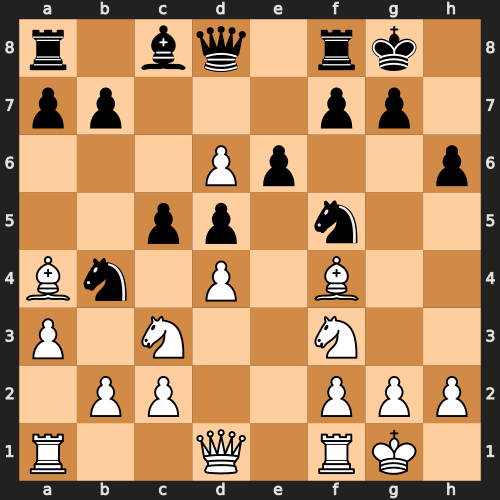

In [14]:
board = chess.Board()
white = Agent("Models/chessbot_neural_network.h5", chess.STARTING_FEN)
black = Agent("Models/chessbot_neural_network.h5", chess.STARTING_FEN)

game = Game(env=ChessEnv(), white=white, black=black)

display(chess.svg.board(board=board, size=500))
while is_game_finished(board) == False:
    try:
        # use mcts to find best move
        move = str(input("Enter your move: "))
        if move == "quit" or move == "exit" or move == "stop": break
        uci_move = check_move(board, move)
        board = show_board(board, uci_move)
        if is_game_finished(board): break
        
        bot_move = game.best_move(board.fen(), turn=0, stochastic=False)
        board = show_board(board, board.parse_uci(bot_move))
        


    except ValueError as e:
        print(e)

In [91]:
game = chess.pgn.Game.from_board(board)

# Set the headers for the game
game.headers["Event"] = "bot Game"
game.headers["Site"] = "offline vscode"
game.headers["Date"] = time.strftime("%Y.%m.%d")
game.headers["Round"] = "1"
game.headers["White"] = "bot"
game.headers["Black"] = "bot"
game.headers["Result"] = board.result()

print(game)

[Event "bot Game"]
[Site "offline vscode"]
[Date "2023.01.30"]
[Round "1"]
[White "bot"]
[Black "bot"]
[Result "*"]

1. e4 Nc6 2. Nc3 e5 3. Nf3 f6 4. Bc4 Be7 5. O-O a6 6. d3 d6 7. Be3 a5 8. Qd2 Bg4 9. Qe2 g6 10. h3 Bxh3 11. gxh3 Nd4 12. Bxd4 Qd7 13. Kh2 a4 14. Be3 b6 15. d4 d5 16. exd5 O-O-O 17. dxe5 Kb8 18. e6 h6 19. exd7 Rxd7 20. Bb5 g5 21. Bxd7 g4 22. hxg4 a3 23. Qa6 Bd6+ *


In [11]:
while True:
  print("playing games against itself")

  pool = multiprocessing.Pool(processes=40)
  results = pool.map(self_play, range(200))

  train_model()

  print("playing games against new model")

  result = play_test_games()

  if sum(result) < 0:
    print("new model outperformed old one deleting dataset and saving new model as main one")

    for game in os.listdir("Memory"):
        os.remove(os.path.join("Memory", game))

    model = load_model("Models/chessbot_neural_network_v2.h5")
    model.save("Models/chessbot_neural_network.h5")

  else:
    print("old model outperformed new one, playing some more games to get more training data")

playing games against itself


NameError: name 'self_play' is not defined